In [18]:
# Import dependencies
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
%matplotlib inline
from scipy.stats import norm
import statsmodels.api as sm
from datetime import datetime
import requests
from io import BytesIO
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

In [4]:
# Import Data
df= pd.read_csv('TotalVacancies_Q32015_Q12021_2021_11_18.csv')
df.head()

,Unnamed: 0,REF_DATE,GEO,DGUID,National Occupational Classification,Job vacancy characteristics,Statistics,VALUE,STATUS
0,1143184,2015-04,Canada,2016A000011124,"Total, all occupations","Type of work, all types",Job vacancies,451925.0,A
1,2286368,2015-07,Canada,2016A000011124,"Total, all occupations","Type of work, all types",Job vacancies,407865.0,A
2,3429552,2015-10,Canada,2016A000011124,"Total, all occupations","Type of work, all types",Job vacancies,358755.0,A
3,4572736,2016-01,Canada,2016A000011124,"Total, all occupations","Type of work, all types",Job vacancies,330215.0,A
4,5715920,2016-04,Canada,2016A000011124,"Total, all occupations","Type of work, all types",Job vacancies,391190.0,A


In [ ]:
df.info()

In [5]:
# drop all unnecessary columns 
df = df.loc[:,['REF_DATE','VALUE']]
df.head()

,REF_DATE,VALUE
0,2015-04,451925.0
1,2015-07,407865.0
2,2015-10,358755.0
3,2016-01,330215.0
4,2016-04,391190.0


In [6]:
df.rename(columns={'VALUE':'TotalVacancies'}, inplace=True)
df.head()

,REF_DATE,TotalVacancies
0,2015-04,451925.0
1,2015-07,407865.0
2,2015-10,358755.0
3,2016-01,330215.0
4,2016-04,391190.0


In [7]:
df['TotalVacancies'].sum()

9288000.0

In [8]:
#  convert the REF_DATE column into a datetime object
df['REF_DATE'] = pd.to_datetime(df['REF_DATE'], format='%Y-%m')
df.head(19)

,REF_DATE,TotalVacancies
0,2015-04-01,451925.0
1,2015-07-01,407865.0
2,2015-10-01,358755.0
3,2016-01-01,330215.0
4,2016-04-01,391190.0
5,2016-07-01,404860.0
6,2016-10-01,381010.0
7,2017-01-01,387080.0
8,2017-04-01,459685.0
9,2017-07-01,467395.0


In [9]:
df.set_index('REF_DATE', inplace=True)
df.shape

(20, 1)

## Time series Analysis 

In [10]:
#visualize the time series data

(array([16436., 16801., 17167., 17532., 17897., 18262.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

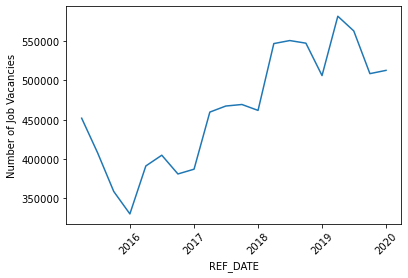

In [11]:
sns.lineplot(data= df, x='REF_DATE', y= 'TotalVacancies')
plt.ylabel('Number of Job Vacancies')
plt.xticks(rotation=45)

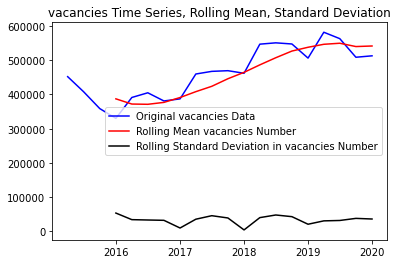

In [12]:
'''check for stationary
A stationary time series will not have any trends or seasonal patterns
We will use the Dickey Fuller test to check for stationarity in our data '''

rolling_mean = df.rolling(4).mean()
rolling_std = df.rolling(4).std()

#First, let’s make a Matplotlib plot of our time series
plt.plot(df, color="blue",label="Original vacancies Data")
# then the rolling mean
plt.plot(rolling_mean, color="red", label="Rolling Mean vacancies Number")
#And finally, the rolling standard deviation:
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in vacancies Number")
#Let’s then add a title:
plt.title("vacancies Time Series, Rolling Mean, Standard Deviation")
#And a legend:
plt.legend(loc="best")

In [13]:
#We will use the Dickey Fuller test to check for stationarity in our data
from statsmodels.tsa.stattools import adfuller
df_test=df.iloc[:,0].values
adft = adfuller(df_test,autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0  -1.354507              Test Statistics
1   0.603882                      p-value
2   7.000000             No. of lags used
3  12.000000  Number of observations used
4  -4.137829          critical value (1%)
5  -3.154972          critical value (5%)
6  -2.714477         critical value (10%)


our data is not stationary as p value is higher than 0.05

In [15]:
# Checking for autocorrelation in time series data
# This is a measure of how correlated time series data is at a given point in time with past values
autocorrelation_lag1 = df['TotalVacancies'].autocorr(lag=1)
print("One Quarter Lag: ", autocorrelation_lag1)

autocorrelation_lag2 = df['TotalVacancies'].autocorr(lag=2)
print("Two Quaretrs Lag: ", autocorrelation_lag2)

autocorrelation_lag3 = df['TotalVacancies'].autocorr(lag=3)
print("Three Quaretrs Lag: ", autocorrelation_lag3)

autocorrelation_lag4 = df['TotalVacancies'].autocorr(lag=4)
print("Four Quaretrs Lag: ", autocorrelation_lag4)

One Quarter Lag:  0.8417507442893579
Two Quaretrs Lag:  0.6965572514223229
Three Quaretrs Lag:  0.6788911778498717
Four Quaretrs Lag:  0.7749030868093133


the data is autocorrelated

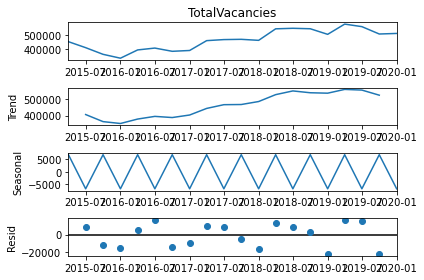

In [16]:
#Check for Trend decomposition is another useful way to visualize the trends in time series data
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['TotalVacancies'],model='additive', period=2)
decompose.plot()
plt.show()

From this plot, we can clearly see the increasing trend in number of vacancies and the seasonality patterns in the rise and fall in values each year.

C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


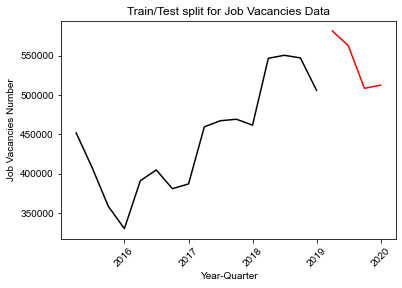

In [17]:
# Forescasting
df['REF_DATE']=df.index
train = df[df['REF_DATE'] < "2019-04-01"]
train['train'] = train['TotalVacancies']
del train['REF_DATE']
del train['TotalVacancies']

test = df[df['REF_DATE'] >= "2019-04-01"]
del test['REF_DATE']
test['test'] = test['TotalVacancies']
del test['TotalVacancies']

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Job Vacancies Data")
plt.ylabel("Job Vacancies Number")
plt.xlabel('Year-Quarter')
plt.xticks(rotation=45)
sns.set()
plt.show()

## SARIMA

source: https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

In [19]:
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

In [20]:
# Dataset
data = df
data.index = data.REF_DATE
# Set the frequency
data.index.freq="QS-OCT"

# Fit the model (configuration is set using previous autocorreleation, trend decomposition tests)
mod = sm.tsa.statespace.SARIMAX(train, trend='t', order=(1,0,1),seasonal_order=(1, 1, 1, 2))
res = mod.fit(disp=False)
print(res.summary())

C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                     
Dep. Variable:                             train   No. Observations:                   16
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 2)   Log Likelihood                -173.868
Date:                           Fri, 19 Nov 2021   AIC                            359.736
Time:                                   10:11:04   BIC                            363.571
Sample:                               04-01-2015   HQIC                           359.381
                                    - 01-01-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       -977.1508      0.000  -2.77e+06      0.000    -977.152    -977.150
ar.L1         -0.6853      0.079     -8.722

C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [31]:
# forecast values for test data
forecast = res.predict(test.index[0],test.index[-1], dynamic=True)
forecast = pd.DataFrame(forecast.values,index = test.index,columns=['Prediction'])
forecast.head()

,Prediction
REF_DATE,
2019-04-01,587407.392035
2019-07-01,549985.454825
2019-10-01,535895.200785
2020-01-01,495415.010295


In [23]:
# create dataframe for results
output = test.merge(forecast, how='inner', left_index=True, right_index=True)
output.head()

,test,Prediction
REF_DATE,,
2019-04-01,581595.0,587407.392035
2019-07-01,562910.0,549985.454825
2019-10-01,508590.0,535895.200785
2020-01-01,512760.0,495415.010295


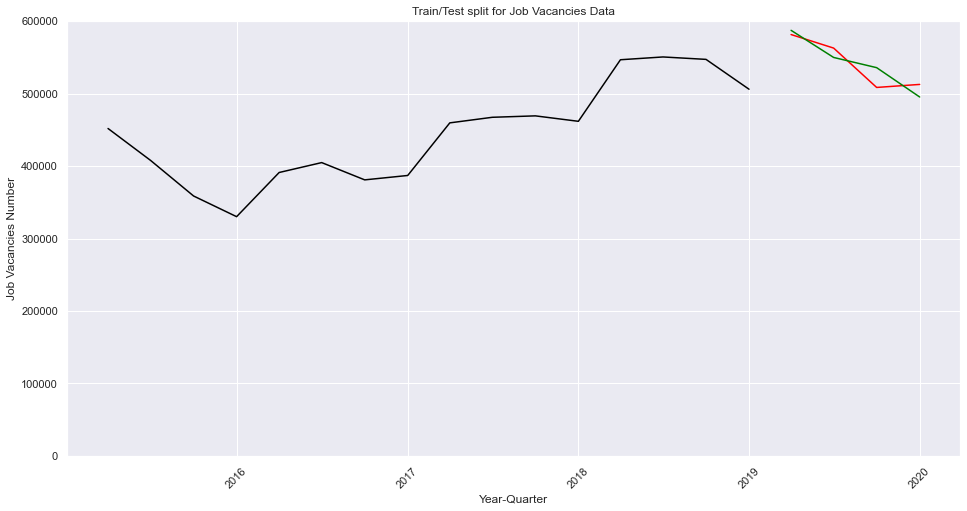

In [24]:
#visualize results
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(forecast['Prediction'],color= 'green')
plt.title("Train/Test split for Job Vacancies Data")
plt.ylabel("Job Vacancies Number")
plt.xlabel('Year-Quarter')
plt.xticks(rotation=45)
plt.ylim(ymin=0)
sns.set()
plt.show()

In [28]:
# check model accuaracy with actual values from statCan
Actual=[560215,553480,731905]
predict_quarters=['2020-10-01','2021-01-01','2021-04-01']

forecast_data=[]
counter=0
for i in predict_quarters:
    forecast_test = res.predict(i)
    forecast_data.append(forecast_test)
    counter +=1
    
forecast_data

[2020-10-01    522737.441305
 Freq: QS-OCT, dtype: float64,
 2021-01-01    481961.986259
 Freq: QS-OCT, dtype: float64,
 2021-04-01    560978.298278
 Freq: QS-OCT, dtype: float64]

In [47]:
forecast_data[2].index # list of dataframes

DatetimeIndex(['2021-04-01'], dtype='datetime64[ns]', freq='QS-OCT')

In [52]:
#keep only forecast numbers
[int(f.values[0]) for f in forecast_data]

[522737, 481961, 560978]

In [53]:
# create results dataframe
forecast_df= pd.DataFrame({'Predicted Value':[int(f.values[0]) for f in forecast_data], 'Actual Value': Actual}, index=predict_quarters)
forecast_df.head()

,Predicted Value,Actual Value
2020-10-01,522737,560215
2021-01-01,481961,553480
2021-04-01,560978,731905


In [94]:
# Function to apply timeseries model on province level
def province_vac (province):
    import warnings
    warnings.filterwarnings("ignore")
    df_prov= pd.read_csv('DataforMLtesting.csv')
    #  convert the REF_DATE column into a datetime object
    df_prov['REF_DATE'] = pd.to_datetime(df_prov['REF_DATE'], format='%Y-%m')
    #select province data 
    prov_vac= df_prov.loc[df_prov['GEO']== str(province),:] 
    # drop all unnecessary columns
    prov_vac = prov_vac.loc[:,['REF_DATE','VALUE']]
    # aggregate total vacancies per quarter
    prov_vac= prov_vac.groupby(prov_vac['REF_DATE']).sum()
    #remove Q32020 onwards
    prov_vac= prov_vac.loc['2015-04-01':'2020-01-01']
    # rename columns
    prov_vac.rename(columns={'VALUE':f'{province}_TotalVacancies'}, inplace=True)
    #visualize the time series data
    sns.lineplot(data= prov_vac, x='REF_DATE', y= f'{province}_TotalVacancies')
    plt.ylabel('Number of Job Vacancies')
    plt.xticks(rotation=45)
    
    #check for stationary using the Dickey Fuller test to check for stationarity in our data
    rolling_mean = prov_vac.rolling(4).mean()
    rolling_std = prov_vac.rolling(4).std()
    #First, make a Matplotlib plot of our time series
    plt.plot(prov_vac, color="blue",label="Original vacancies Data")
    # then the rolling mean
    plt.plot(rolling_mean, color="red", label="Rolling Mean vacancies Number")
    #And finally, the rolling standard deviation:
    plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in vacancies Number")
    #add a title:
    plt.title(f'{province} vacancies Time Series, Rolling Mean, Standard Deviation')
    #And a legend:
    plt.legend(loc="best")
    #use the Dickey Fuller test to check for stationarity in our data
    from statsmodels.tsa.stattools import adfuller
    prov_vac_test=prov_vac.iloc[:,0].values
    adft_prov = adfuller(prov_vac_test,autolag="AIC")
    output_prov_df = pd.DataFrame({"Values":[adft_prov[0],adft_prov[1],adft_prov[2],adft_prov[3], adft_prov[4]['1%'], adft_prov[4]['5%'], adft_prov[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    print('Stationary Test Results')
    print(output_prov_df)
    
    # Checking for autocorrelation in time series data
    print('Autocorrelation Results')
    autocorrelation_lag1_prov = prov_vac[f'{province}_TotalVacancies'].autocorr(lag=1)
    print("One Quarter Lag: ", autocorrelation_lag1_prov)
    autocorrelation_lag2_prov = prov_vac[f'{province}_TotalVacancies'].autocorr(lag=2)
    print("Two Quaretrs Lag: ", autocorrelation_lag2_prov)
    autocorrelation_lag3_prov = prov_vac[f'{province}_TotalVacancies'].autocorr(lag=3)
    print("Three Quaretrs Lag: ", autocorrelation_lag3_prov)
    autocorrelation_lag4_prov = prov_vac[f'{province}_TotalVacancies'].autocorr(lag=4)
    print("Four Quaretrs Lag: ", autocorrelation_lag4_prov)
    
    #Check for Trend decomposition to visualize the trends in time series data
    from statsmodels.tsa.seasonal import seasonal_decompose
    decompose_prov = seasonal_decompose(prov_vac[f'{province}_TotalVacancies'],model='additive', period=2)
    decompose_prov.plot()
    print('Trend Decomposition Visualization')
    plt.show()
    
    # Forescasting
    prov_vac['REF_DATE']=prov_vac.index
    train_prov = prov_vac[prov_vac['REF_DATE'] < "2019-04-01"]
    train_prov[f'train_{province}'] = train_prov[f'{province}_TotalVacancies']
    del train_prov['REF_DATE']
    del train_prov[f'{province}_TotalVacancies']

    test_prov = prov_vac[prov_vac['REF_DATE'] >= "2019-04-01"]
    del test_prov['REF_DATE']
    test_prov[f'test_{province}'] = test_prov[f'{province}_TotalVacancies']
    del test_prov[f'{province}_TotalVacancies']

    # Register converters to avoid warnings
    pd.plotting.register_matplotlib_converters()
    plt.rc("figure", figsize=(16,8))
    plt.rc("font", size=14)
    
    # Dataset
    data_prov = prov_vac
    data_prov.index = data_prov.REF_DATE
    # Set the frequency
    data_prov.index.freq="QS-OCT"

    # Fit the model (configuration is set using previous autocorreleation, trend decomposition tests)
    mod_prov = sm.tsa.statespace.SARIMAX(train_prov, trend='t', order=(0,1,0),seasonal_order=(1, 1, 1, 2))
    res_prov = mod_prov.fit(disp=False)
    print(res_prov.summary())
    
    # produce forecast results
    forecast_prov = res_prov.predict(test_prov.index[0],test_prov.index[-1], dynamic=True)
    forecast_prov = pd.DataFrame(forecast_prov.values,index = test_prov.index,columns=[f'Prediction_{province}'])
    output_prov = test_prov.merge(forecast_prov, how='inner', left_index=True, right_index=True)
    print('Forecast Results')
    print(output_prov)
    
    #plot results
    plt.plot(train_prov, color = "black")
    plt.plot(test_prov, color = "red")
    plt.plot(forecast_prov[f'Prediction_{province}'],color= 'green')
    plt.title(f"Train/Test/Forecast split for {province} Job Vacancies Data")
    plt.ylabel("Job Vacancies Number")
    plt.xlabel('Year-Quarter')
    plt.xticks(rotation=45)
    plt.ylim(ymin=0)
    sns.set()
    plt.show()
    
    
  

Stationary Test Results
      Values                       Metric
0  -1.399623              Test Statistics
1   0.582457                      p-value
2   0.000000             No. of lags used
3  19.000000  Number of observations used
4  -3.832603          critical value (1%)
5  -3.031227          critical value (5%)
6  -2.655520         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.8183282290716961
Two Quaretrs Lag:  0.7233008554808513
Three Quaretrs Lag:  0.6668521506991204
Four Quaretrs Lag:  0.760705401884391
Trend Decomposition Visualization


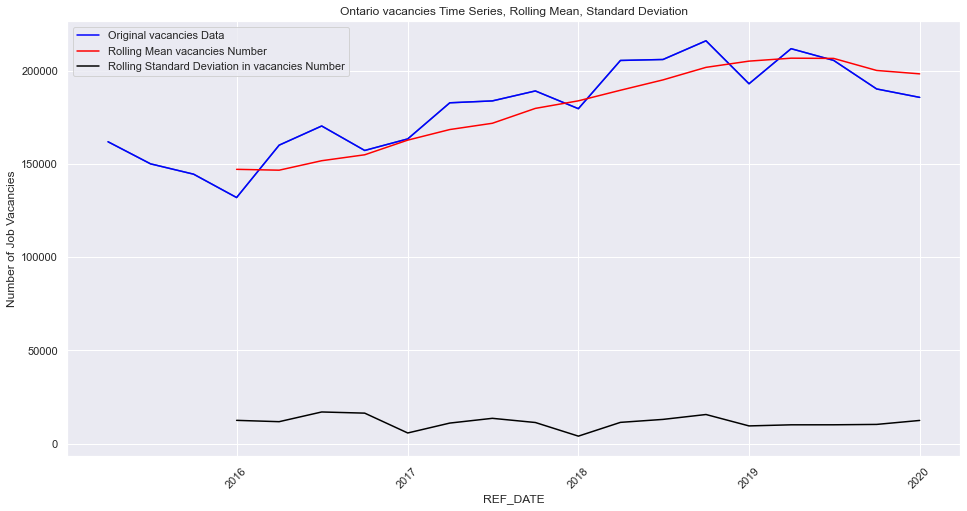

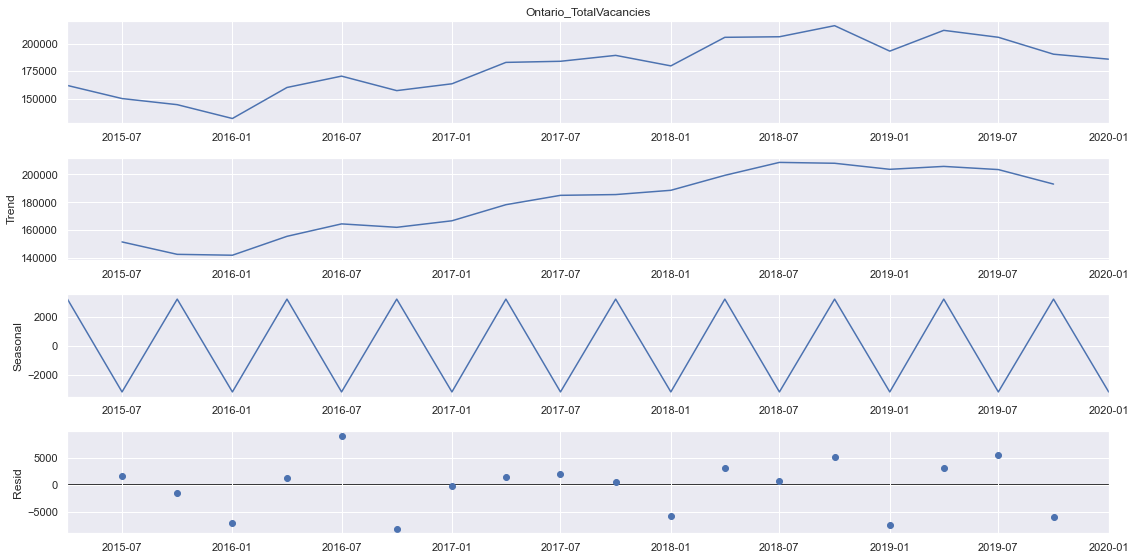

                                      SARIMAX Results                                      
Dep. Variable:                       train_Ontario   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                -140.820
Date:                             Fri, 19 Nov 2021   AIC                            289.640
Time:                                     15:17:47   BIC                            291.900
Sample:                                 04-01-2015   HQIC                           289.175
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        243.9646    974.989      0.250      0.802   -1666.978    2154.908
ar.S.L2       -0.8442      

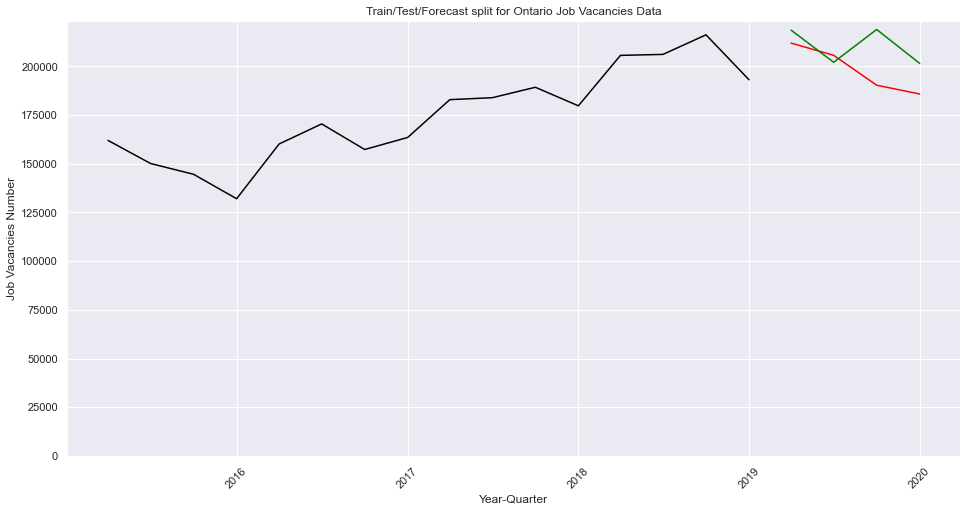

In [95]:
#example output on province level
province_vac('Ontario')